# Recurrent Neural Network

Let's try throwing a neural network at the demand forecasting problem.  We'll give input method the day of the week, time of day, day of the year, and temperature.  This first version uses a single recurrent cell, with a linear layer at the end.  This could be enhanced by making deeper networks at both the beginning and end, using a fancier cell (LSTM, GRU).

The networks will be trained on one year's worth of data, and then tested on the remainder.

Why do I think this is a good candidate for using a neural network?
One, there's obviously some clear structure here.
Two, there's the possibility of non-linear effects and correlations
across multiple stations. Particularly for large temperature swings.
So its seems there's some pattern, some randomness, but not too much.
I also wanted to get some experience using these neural network forecasting techniques in a fairly simple context.

But, this doesn't really hit at a neural network's strength at pulling out complex patterns from huge data.

## The Model

The desired basic model is one which can take the time of day and year, as well as the estimated temperature
and forecasts a number of corresponding demand values. 
(I'm using the actual historical temperatures, but in reality it would have to be a forecast.)

\begin{equation}
d_t = f_{NN}(T,\text{time})
\end{equation}

If we think of the neural network as a nonlinear extension of the prior models, it would be also include the historical demand for an autoregression.


## TODO

- fix the graph to be as desired. 
- visualization for input weights. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import BasicRNNCell,LSTMCell

from util.get_weather_data import convert_isd_to_df, convert_state_isd
from util.EBA_util import remove_na, avg_extremes, rmse, mape

from tf_rnn import recurrentNeuralNetwork, RNNConfig
from tf_rnn import simpleRecurrentNeuralNetwork as sRNN

%matplotlib inline
%load_ext autoreload
%autoreload 2


ModuleNotFoundError: No module named 'tensorflow.contrib'

In [2]:
#Extend to multiple temperature series
try:
    df_joint=pd.read_csv('data/pdx_joint.txt',
        index_col=0, parse_dates=True)
    print('Read in PDX Frame from file')
except:
    print('Creating PDX DataFrame from scratch')
    air_df = pd.read_csv('data/air_code_df.gz')
    #Just get the weather station data for cities in Oregon.
    df_weather=convert_state_isd(air_df,'OR')
    #Select temperature for only Portland
    #msk1=np.array(df_weather['city']=='Portland')
    #select temp for all Oregon stations
    msk2=np.array(df_weather['state']=='OR')
    df_pdx_weath=df_weather.loc[msk2]
    #find number of unique station city/state combinations
    Nstation = len(df_pdx_weath['city, state'].unique())

    #reshape the single temperature column into Nstation copies.  
    unique_station=df_pdx_weath['city, state'].unique()
    temp_df=pd.DataFrame()
    for station in unique_station:
        colname=str('Temp-'+station)
        temp_df[colname]=df_pdx_weath.loc[df_pdx_weath['city, state']==station,'Temp']

    #get electricity data for Portland General Electric
    df_eba=pd.read_csv('data/EBA_time.gz',index_col=0,parse_dates=True)
    msk=df_eba.columns.str.contains('Portland')
    df_pdx=df_eba.loc[:,msk]
    #select out demand data
    msk1 = df_pdx.columns.str.contains('[Dd]emand') 
    dem=df_pdx.loc[:,msk1]
    #Make a combined Portland Dataframe for demand vs weather.
    df_joint=pd.DataFrame(dem)
    df_joint=df_joint.join(temp_df)
    df_joint = df_joint.rename(columns={df_joint.columns[0]:'Demand',
             df_joint.columns[1]:'Forecast'})
    df_joint.to_csv('data/pdx_joint.txt')

#Make copies of data from dataframe to avoid overwriting source data.
dem=df_joint['Demand'].copy()
temp=df_joint.loc[:,df_joint.columns.str.contains('Temp')].copy()
fore=df_joint['Forecast'].copy()

Read in PDX Frame from file


The actual data again has lots of missing values, or zero values.
This imputes missing values based on the average
of the yesterdays and tomorrows values at the same time.

In [3]:
#clean up data, remove NA
#remove NA values, and average extreme values down
for y in [temp,dem]:
    if len(y.shape)>1:
        for i in range(y.shape[1]):
            x= y.iloc[:,i]
            x = remove_na(x)
            y.iloc[:,i] = avg_extremes(x)
    else:
        x= y
        x = remove_na(x)
        y = avg_extremes(x)


Number of NA values 55
Number of extreme values 1. Number of zero values 189
Number of NA values 56
Number of extreme values 0. Number of zero values 148
Number of NA values 56
Number of extreme values 1. Number of zero values 0
Number of NA values 156
Number of extreme values 1. Number of zero values 3


In [5]:
def make_temptime_data(temp_mat):
    """make_input_data
    Takes input temperature data matrix (for multiple locations),
    and extends with extra indices for time of day, day of year, day of week, and holiday. 

    Input: temp_mat - pandas series of temperatures a location.  
    Output: in_mat - matrix of raw temperatures, and scaled times of day and year.
    """
    Tind = temp_mat.index
    Nt=len(Tind)
    hr = Tind.hour.values/(24-1)
    #scale day of year to [0,1]
    dyear = Tind.dayofyear.values/(365-1+Tind.is_leap_year.astype(int))
    dweek = Tind.dayofweek.values/(7-1)
    # #scale temperature data to so that max/min correspond to [0,1]  
    # temp_max = temp_mat.max(axis=0)
    # temp_min = temp_mat.min(axis=0)
    # temp_mat = (temp_mat-temp_min)/(temp_max-temp_min)
    out_mat=np.stack([hr,dweek,dyear]).T
    out_mat= np.hstack([temp_mat.values,out_mat])
    return out_mat


In [17]:
# ##OBSOLETE - REMOVING!

# def scale_demand(dem):
#     """scale_demand
#     Scale demand to be on 0,1 scale.
#     Input: demand - series at single location
#     Output: dem_scale - scaled array of values.
#             dem_max, dem_min - the maximum and minimum values.
#     """
#     dem_scale = dem.values
#     dem_max = np.max(dem_scale)
#     dem_min = np.min(dem_scale)
#     dem_scale = (dem_scale-dem_min)/(dem_max-dem_min)
#     return dem_scale, dem_max,dem_min

# #drop data prior to 
# temp_mat,tmax,tmin=make_temptime_data(temp[:Ntest])
# dem_mat,dmax,dmin=scale_demand(dem)

# temp_train = temp_mat[0:Ntest,:]
# temp_test = temp_mat[Ntest:,:]
# dem_train = dem_mat[0:Ntest]
# dem_test = dem_mat[Ntest:]

In [6]:
#make combined temperature and time data.
temp_mat=make_temptime_data(temp)

In [7]:
#Use Sklearn MinMaxScaler to scale all data between 0,1.
#Only fit the scaling on training data.

Nt=len(dem)
Ntest = Nt//2

Tscaler=MinMaxScaler()
Dscaler=MinMaxScaler()
Tscaler.fit(temp_mat[:Ntest])
Dscaler.fit(dem[:Ntest].values.reshape((Ntest,1)))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
#need the reshape for demand since only has shape (nrow,) rather than (nrow,1)
dem_scale=Dscaler.transform(dem.values.reshape(-1,1))
temp_scale=Tscaler.transform(temp_mat)

temp_train = temp_scale[0:Ntest,:]
temp_test = temp_scale[Ntest:,:]

dem_train = dem_scale[0:Ntest]
dem_test = dem_scale[Ntest:]


In [20]:
#need the reshape for demand since only has shape (nrow,) rather than (nrow,1)
dem_scale=Dscaler.transform(dem.values.reshape(-1,1))
temp_scale=Tscaler.transform(temp_mat)

temp_train = temp_scale[0:Ntest,:]
temp_test = temp_scale[Ntest:,:]

dem_train = dem_scale[0:Ntest]
dem_test = dem_scale[Ntest:]


In [11]:
def get_random_batch(X,y,n_batch,seq_len):
    """get_random_batch(Xsig,t,n_batch)   
    Gets multiple random samples for the data.
    Samples generated by 'get_selection' function.
    Makes list of returned entries.
    Then combines together with 'stack' function at the end.

    X - matrix of inputs, (Nt, Ninputs)
    y - vector of desired outputs (Nt)
    n_batch - number of batches
    seq_len - length of sequence to extract in each batch

    Outputs:
    X_batch - random subset of inputs shape (Nbatch,seq_len,Ninputs) 
    y_batch - corresponding subset of outputs (Nbatch,seq_len)
    """
    Nt,Nin = X.shape
    x_list=[]
    y_list=[]
    for i in range(n_batch):
        n0=int(np.random.random()*(Nt-seq_len-1))
        x_sub = X[n0:n0+seq_len]
        y_sub = y[n0:n0+seq_len]
        x_list.append(x_sub)
        y_list.append(y_sub)
    x_batch=np.stack(x_list,axis=0)
    y_batch=np.stack(y_list,axis=0)
    y_batch=y_batch.reshape( [n_batch,seq_len,-1])                    
    return x_batch,y_batch

#Xb,yb=get_random_batch(temp_mat,dem_mat,1000,24)


In [43]:
n_steps=24
n_inputs=len(temp.iloc[0])+3
n_neurons=120
n_layers=3
n_outputs=1  #number of stations to predict at that time.
lr=1E-2
n_iter=4000
n_batch=50

np.random.seed(seed=3453)

In [13]:
def make_RNN_cell(n_neurons,fn=tf.nn.relu):
    cell=BasicRNNCell(num_units=n_neurons,activation=fn)
    return cell

In [44]:
#Initial test with code liberally borrowed from ch14 of Geron's 
#"Practical Machine Learning with scikit-learn and Tensorflow"

#Makes a single RNN cell, with a fully connected output layer (with no activation on the output).

print('setting up graphs:Multi-layer RNN')
tf.reset_default_graph()
#inputs:  Nobs, with n_steps, and n_inputs per step
X = tf.placeholder(tf.float32,[None,n_steps,n_inputs],name='X')
#Outputs: n_outputs we want to predict in the future.
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs],name='y')

#define neural network shape

#Make a list of cells to pass along.  
cell_list=[]
for i in range(n_layers):
    cell_list.append(make_RNN_cell(n_neurons,tf.nn.relu))

multi_cell=tf.contrib.rnn.MultiRNNCell(cell_list,state_is_tuple=True)
#Note that using [cell]*n_layers did not work since that copies the memory location, rather than making
#a number of independent copies.
rnn_outputs,states=tf.nn.dynamic_rnn(multi_cell,X,dtype=tf.float32)
#this maps the number of hidden units to fewer outputs.
stacked_rnn_outputs = tf.reshape(rnn_outputs,[-1,n_neurons])
stacked_outputs = fully_connected(stacked_rnn_outputs,n_outputs,activation_fn=None)
outputs=tf.reshape(stacked_outputs,[-1,n_steps,n_outputs])

#define loss (mean-square-error)
loss = tf.reduce_mean(tf.square(outputs-y))
#define optimization function.
optimizer=tf.train.AdamOptimizer(learning_rate=lr)
training_op=optimizer.minimize(loss)
init=tf.global_variables_initializer()

saver = tf.train.Saver()
#Try adding everything by name to a collection to save and restore later
tf.add_to_collection('X',X)
tf.add_to_collection('y',y)
tf.add_to_collection('loss',loss)
tf.add_to_collection('pred',outputs)
tf.add_to_collection('train',training_op)

#compute number correct.
print('Loading data')
run_network=True

if (run_network==True):
    print('Running this thang')
    with tf.Session() as sess:
        init.run()
        for iteration in range(n_iter):
            #select random starting point. 
            X_batch,y_batch=get_random_batch(
                            temp_train, dem_train, n_batch, n_steps)

            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
            if iteration%50 ==0:
                mse =loss.eval(feed_dict={X:X_batch,y:y_batch})
                print("MSE on batch ",iteration,':\t',mse)
                #save model
                saver.save(sess, "./models/pdx_RNN_model",
                           write_meta_graph=True)

setting up graphs:Multi-layer RNN
Loading data
Running this thang
MSE on batch  0 :	 163.06
MSE on batch  50 :	 0.0165628
MSE on batch  100 :	 0.0101029
MSE on batch  150 :	 0.00757224
MSE on batch  200 :	 0.00501968
MSE on batch  250 :	 0.004303
MSE on batch  300 :	 0.00516284
MSE on batch  350 :	 0.00340279
MSE on batch  400 :	 0.00610854
MSE on batch  450 :	 0.0047167
MSE on batch  500 :	 0.00301853
MSE on batch  550 :	 0.00359529
MSE on batch  600 :	 0.0037216
MSE on batch  650 :	 0.00308034
MSE on batch  700 :	 0.00342115
MSE on batch  750 :	 0.00343717
MSE on batch  800 :	 0.00284829
MSE on batch  850 :	 0.00412134
MSE on batch  900 :	 0.00370268
MSE on batch  950 :	 0.0025988
MSE on batch  1000 :	 0.00205408
MSE on batch  1050 :	 0.00317277
MSE on batch  1100 :	 0.00353339
MSE on batch  1150 :	 0.00270234
MSE on batch  1200 :	 0.00219397
MSE on batch  1250 :	 0.00481636
MSE on batch  1300 :	 0.00196181
MSE on batch  1350 :	 0.00282448
MSE on batch  1400 :	 0.00202179
MSE on batc

So multiple tanhs are bad.  A couple ReLU layers seem to work well, but do lead to negative predictions.  Note that in comparisons that the early 2015 data is pretty flaky (like the forecasts are zero, and I had to fix multiple issues in the demand data).

In [46]:
def model_predict_whole(Xin,path_str="pdx_RNN_model"):
    """model_predict_whole(tstart)
    Retrieve the outputs of the network for all values of the inputs 
    """
    Nt,Nin=Xin.shape
    nmax = int(Nt/n_steps)
    ytot = np.zeros((Nt,1))
    #Note that loading/saving graph is not properly implemented yet.    
    #reset graph, and reload saved graph
    tf.reset_default_graph()
    model_path = "./models/"+path_str    
    saver = tf.train.import_meta_graph(model_path+".meta")
    #saver=tf.train.import_meta_graph(full_model_name+'.meta')
    #restore graph structure
    X=tf.get_collection('X')[0]
    y=tf.get_collection('y')[0]
    outputs=tf.get_collection('pred')[0]
    train_op=tf.get_collection('train_op')[0]
    loss=tf.get_collection('loss')[0]
    #restores weights etc.
    #saver.restore(sess,full_model_name)
    
    with tf.Session() as sess:

        #restore variables
        saver.restore(sess,model_path)
        for i in range(nmax-1):
            n0=n_steps*i
            x_sub = Xin[n0:n0+n_steps,:]
            x_sub = x_sub.reshape(-1,n_steps,Nin)
            y_pred=sess.run(outputs,feed_dict={X:x_sub})
            #nn_pred=predict_on_batch(sess,X_batch)            
            ytot[n0:n0+n_steps]=y_pred
    return ytot

In [47]:
def plot_whole_sample_fit(X,y,ntest,n_steps,path_str="pdx_RNN_model"):
    """plot_whole_sample_fit

    Plot ALL of the predictions of the trained model
    on a 'test' set with different noise, and longer
    times.  Concatenates the predicted results together.  
    """
    #pull in the inputs, and predictions
    Nt, Nin = X.shape
    ytot=model_predict_whole(X,path_str)
    plt.figure()
    #now plot against the test sets defined earlier
    plt.plot(np.arange(0,ntest),X[:ntest,0],'b',label='Training')
    plt.plot(np.arange(ntest,Nt), X[ntest:,0],'g',label='Test')
    plt.plot(np.arange(Nt),ytot,'r',label='Predicted')
    plt.plot(np.arange(Nt),dem_scale,label='Real')
    plt.legend(loc='right')
    plt.show()
    return ytot

INFO:tensorflow:Restoring parameters from ./models/pdx_RNN_model


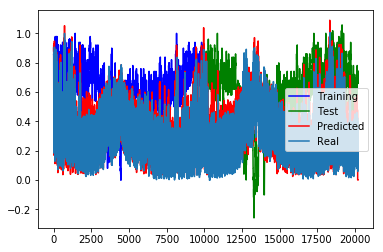

In [48]:
#n0,x_sub,y_pred=toy_predict(2.5)
ytot=plot_whole_sample_fit(temp_scale,dem_scale,Ntest,n_steps,'pdx_RNN_model')

In [25]:
?Dscaler

In [49]:
#convert the RNN output to a pandas time-series
pred=pd.Series(Dscaler.inverse_transform(ytot).reshape(-1),index=dem.index)

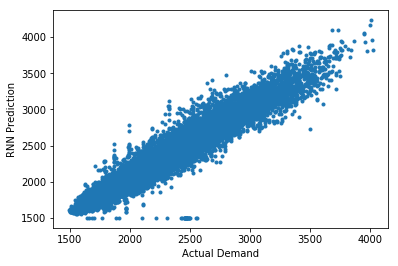

In [50]:
plt.plot(dem['2015-11':],pred['2015-11':],'.')
plt.xlabel('Actual Demand')
plt.ylabel('RNN Prediction')
plt.show()

So let's compute some actual figures here: What was the mean error over the training and test periods?

In [51]:
nt = len(ytot)//2
fore_train_rmse=rmse(fore[:nt],dem[:nt])
fore_test_rmse=rmse(fore[nt:],dem[nt:])
pred_train_rmse=rmse(pred[:nt],dem[:nt])
pred_test_rmse=rmse(pred[nt:],dem[nt:])

print("Forecast RMSE in training/test      : {}, {}".format(fore_train_rmse,fore_test_rmse))
print("RNN Prediction RMSE in training/test: {}, {}".format(pred_train_rmse,pred_test_rmse))

Forecast RMSE in training/test      : 174.69476178243696, 84.06011120151884
RNN Prediction RMSE in training/test: 114.98002002311735, 148.07274601257885


Let's also check the mean absolute percentage error, and also compare against a persistence forecast.

In [52]:
fore_train_mape=mape(fore[:nt],dem[:nt])
fore_test_mape=mape(fore[nt:],dem[nt:])

pers_train_mape=mape(dem[:nt-24].values,dem[24:nt].values)
pers_test_mape=mape(dem[nt:-24].values,dem[nt+24:].values)

pred_train_mape=mape(pred[:nt],dem[:nt])
pred_test_mape=mape(pred[nt:],dem[nt:])

print("Forecast MAPE in training/test      : {}, {}".format(fore_train_mape,fore_test_mape))
print("Persistence MAPE in training/test   : {}, {}".format(pers_train_mape,pers_test_mape))
print("RNN Prediction MAPE in training/test: {}, {}".format(pred_train_mape,pred_test_mape))

Forecast MAPE in training/test      : 0.03083559781902836, 0.025407175204897305
Persistence MAPE in training/test   : 0.05668131298764103, 0.05417891849965209
RNN Prediction MAPE in training/test: 0.0367906778491594, 0.04681192563593824


So this simple RNN does worse than the actual forecast, but does out perform persistence.  Well, that's at least something.
Obviously, this can be greatly improved.  The above is a simple toy model, one input station, one output series for the same set of time.
We can play with other architectures, activations, and using more data.


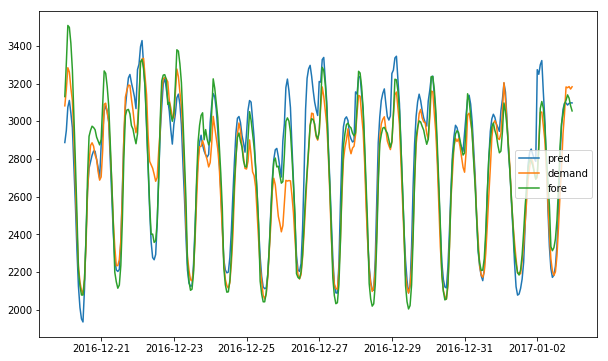

In [53]:
plt.figure(figsize=(10,6))
date_slice=slice('2016-12-20','2017-01-02')
plt.plot(pred[date_slice],label='pred')
plt.plot(dem[date_slice],label='demand')
plt.plot(fore[date_slice],label='fore')
plt.legend(loc='right')
plt.show()

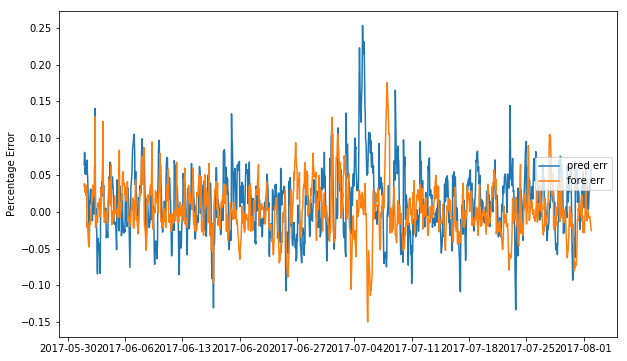

In [54]:
plt.figure(figsize=(10,6))
date_slice=slice('2017-06-01','2017-08-01')
plt.plot(pred[date_slice]/dem[date_slice]-1,label='pred err')
plt.plot(fore[date_slice]/dem[date_slice]-1,label='fore err')
plt.ylabel('Percentage Error')
plt.legend(loc='right')
plt.show()

So looking at the percentage errors, this model (which currently lacks knowledge of holidays) is messing up on Thanksgiving.  Also the model seems to make opposite errors to the forecast model.  It's probably worth checking that the distribution of errors.  Eyeballing the curves shows that the errors are lowest early in the morning, and highest at midday.  The error signal probably has a significant daily frequency component.

Right now this is a 3-layer RNN.  We can extend it to include different cell types, fiddle with the network size, and maybe a different layout.
I'm going to retry this in a more modular approach (and for a more general set of code), with multiple inputs, differing sizes, dropout, more efficient loading.

# Retrying with module

This is going to use similar code in a more OOP framework, and ideally a more powerful, flexible model that can handle time-series of varying lengths, and varying number of input/output variables.

Why do that here?  Well, the toy model only treats PGE, and uses the weather from Portland.  Including weather and energy usage from other nearby places may be a better predictor for each ISO's demand. 

Also, this could then be used to model demand from elsewhere.

Also: why bother with building a separate object? This is all pretty small.
Well, I found that particularly with a Jupyter Notebook it was
easy to lose track of what the status of the variables and graphs was.
(Also Jupyter notebooks break if another cell is called when the debugger is active.
 Only the fact I use the EIN emacs plugin for editting let's me change to the active debugger process and kill that. )

This neatly encapsulates all of that.  (And is easier to modify later, and is, I hope, better programming practice.)


In [128]:
temp_train.shape

(10108, 6)

In [192]:
#from EBA_RNN import EBA_RNN


In [129]:
Nstation=3
NISO=1
Nextra=3
#3 temp series, 3 date variables (hour, day of week, year)
Ninputs=Nstation+Nextra
%pdb off
#Note LSTM/GRU need much smaller learning rates.
rnn_conf=RNNConfig(Ninputs=Ninputs,lr=0.001,keep_prob=0.75,Nepoch=10000,Nhidden=100,cell='RNN',Nprint=20,Nlayers=2)
RNN=recurrentNeuralNetwork(rnn_conf)

Automatic pdb calling has been turned OFF


iter #10000. Current MSE:0.02375207655131817
Total Time taken:2692.6069078445435




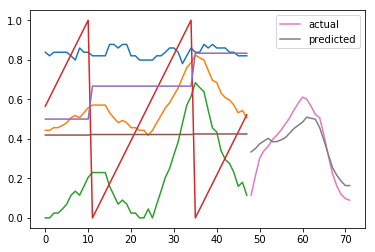

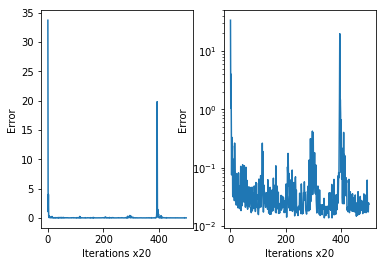

In [130]:
RNN.train_graph(temp_train,dem_train,'models/pdx_test_rnn')

In [131]:
%pdb off
test_pred=RNN.predict_all(temp_scale,'models/pdx_test_rnn')

Automatic pdb calling has been turned OFF
INFO:tensorflow:Restoring parameters from models/pdx_test_rnn-10000
0 2400
2400 2400
4800 2400
7200 2400
9600 2400
12000 2400
14400 2400
16800 1704
18504 840
19344 432
19776 216
19992 96
20088 48
20136 24
20160 24
20184 0
No entries left.  Breaking loop


In [132]:
test_pred_rescale=Dscaler.inverse_transform(test_pred)

In [133]:
test_pred_t=pd.Series(test_pred_rescale.reshape(-1),index=dem.index)

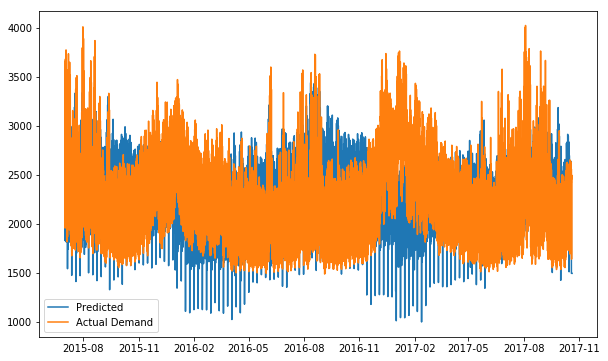

In [134]:
plt.figure(figsize=(10,6))
plt.plot(test_pred_t,label='Predicted')
plt.plot(dem,label='Actual Demand')
plt.legend()
plt.show()

In [235]:
pred.shape,dem.shape,pred_rescale.shape

((20216, 1), (20216,), (20216, 1))

In [118]:
nt=Ntest
fore_train_mape=mape(fore[:nt],dem[:nt])
fore_test_mape=mape(fore[nt:],dem[nt:])

pers_train_mape=mape(dem[:nt-24].values,dem[24:nt].values)
pers_test_mape=mape(dem[nt:-24].values,dem[nt+24:].values)

pred_train_mape=mape(test_pred_rescale[:nt].reshape(-1),dem[:nt])
pred_test_mape=mape(test_pred_rescale[nt:].reshape(-1),dem[nt:])

print("Forecast MAPE in training/test      : {}, {}".format(fore_train_mape,fore_test_mape))
print("Persistence MAPE in training/test   : {}, {}".format(pers_train_mape,pers_test_mape))
print("RNN Prediction MAPE in training/test: {}, {}".format(pred_train_mape,pred_test_mape))

Forecast MAPE in training/test      : 0.03083559781902836, 0.025407175204897305
Persistence MAPE in training/test   : 0.05668131298764103, 0.05417891849965209
RNN Prediction MAPE in training/test: 0.1285184243912, 0.1549308658846444


## Revisit Simple Model

Let's revisit the original simple model (after it's been shoved into a OOP structure in tf\_rnn.py).

In [73]:
Nstation=3
Nextra=3
Ninputs=Nstation+Nextra
%pdb off
srnn_conf=RNNConfig(Ninputs=Ninputs,
                   lr=0.01,
                   keep_prob=1,
                   Nepoch=2000,
                   Nhidden=120,
                   Nlayers=3,
                   Nsteps_in=24,
                   Nsteps_out=24,
                   cell='RNN',Nprint=100)


Automatic pdb calling has been turned OFF


In [75]:
srnn=sRNN(srnn_conf)

iter #2000. Current MSE:0.0012043555034324527
Total Time taken:252.6921308040619




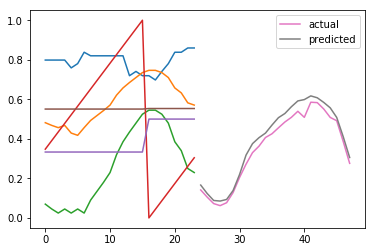

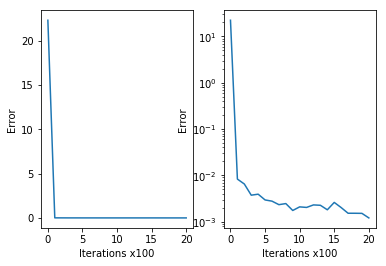

In [76]:
srnn.train_graph(temp_train,dem_train,'models/old_test')

In [78]:
srnn_pred=srnn.predict_all(temp_scale,path_str='old_test-2000')

INFO:tensorflow:Restoring parameters from ./models/old_test-2000


In [79]:
srnn_pred_rescale=Dscaler.inverse_transform(srnn_pred)

In [83]:
srnn_pred_t=pd.Series(srnn_pred_rescale.reshape(-1),index=dem.index)

In [82]:
nt=Ntest
fore_train_mape=mape(fore[:nt],dem[:nt])
fore_test_mape=mape(fore[nt:],dem[nt:])

pers_train_mape=mape(dem[:nt-24].values,dem[24:nt].values)
pers_test_mape=mape(dem[nt:-24].values,dem[nt+24:].values)

srnn_train_mape=mape(srnn_pred_rescale[:nt].reshape(-1),dem[:nt])
srnn_test_mape=mape(srnn_pred_rescale[nt:].reshape(-1),dem[nt:])

print("Forecast MAPE in training/test      : {}, {}".format(fore_train_mape,fore_test_mape))
print("Persistence MAPE in training/test   : {}, {}".format(pers_train_mape,pers_test_mape))
print("RNN Prediction MAPE in training/test: {}, {}".format(srnn_train_mape,srnn_test_mape))

Forecast MAPE in training/test      : 0.03083559781902836, 0.025407175204897305
Persistence MAPE in training/test   : 0.05668131298764103, 0.05417891849965209
RNN Prediction MAPE in training/test: 0.03504992647857292, 0.04108608410660199


In [86]:
dem.index[Ntest]

Timestamp('2016-08-25 04:00:00')

In [100]:
from datetime import datetime


TypeError: an integer is required (got type str)

In [104]:
datetime(2016,11,1)

datetime.datetime(2016, 11, 1, 0, 0)

In [108]:
!cp fig/*png /home/jonathan/talks/Metro/fig

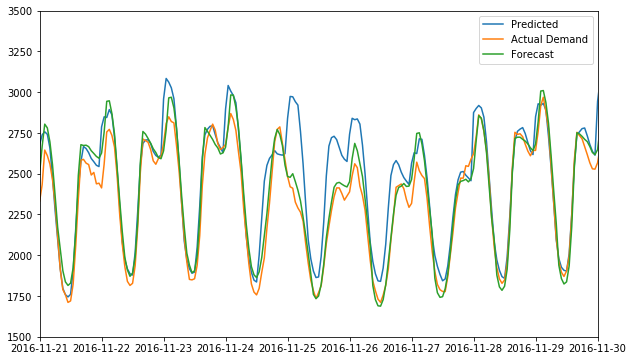

In [107]:
plt.figure(figsize=(10,6))
plt.plot(srnn_pred_t,label='Predicted')
plt.plot(dem,label='Actual Demand')
plt.plot(fore,label='Forecast')
plt.axis([datetime(2016,11,21),datetime(2016,11,30),1500,3500])
plt.legend()
plt.savefig('fig/sRNN_thanksgiving.png')
plt.show()

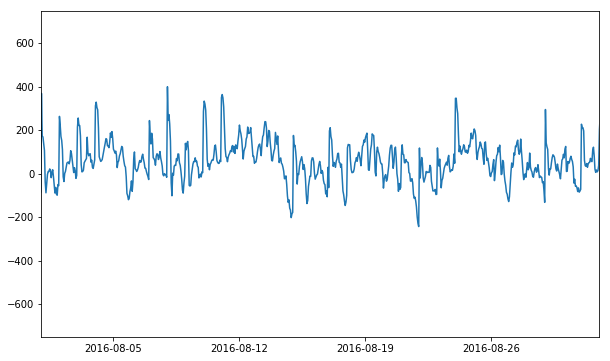

In [89]:
plt.figure(figsize=(10,6))
plt.plot(srnn_pred_t-dem)
plt.axis(['2016-08','2016-09',-750,750])
plt.legend()
plt.show()

In [ ]:
## Need to implement Holidays

We really need to implement a holiday method too. 

## Optimizing the network

So we need to a framework to optimize this based on what learning rate to use, the number of epochs, number of layers, hidden dimensions, dropout rate.

Perhaps leave in a method to determine early stopping?

Surveying the net suggests that a random search would probably work as a baseline.
Otherwise hyperopt seems to be one suggested option which is well maintained and plays nice with Python3.

I'll make my own search.  In this case it make sense to train on half of the data, validate on a remainder set. and Test on the rest.

So this is a time series problem.  We will train on the first year.
Maybe validate alternating days, and test on other alternating days?
The reason for alternation is to get a full variation over a year. 